In [3]:
import sympy as sym
import numpy as np
import scipy as sp

from pygears.transformation import symbolic_transformation, numeric_transformation

t, x, m, xw = sym.symbols(["t", "x", "m", "xw"])
s, alpha, n_t, y, phi = sym.symbols(["s", "alpha", "n_t", "y", "phi"])
r = sym.Function("r")(x, y)
z = sym.Function("z")(x, y, t)

In [4]:
dp = sym.sqrt( (x - xw)**2 + z**2)
dp

sqrt((x - xw)**2 + z(x, y, t)**2)

In [5]:
sym.simplify(sym.diff(dp, x))

(x - xw + z(x, y, t)*Derivative(z(x, y, t), x))/sqrt((x - xw)**2 + z(x, y, t)**2)

In [ ]:
(x - xw + z(x,y,t) * dz_dx(x,y,t) ) / np.sqrt((x - xw)**2 + z(x,y,t)**2 )

In [6]:
z = m * n_t * sym.asin(y / r) / 2 + (r - xw) * sym.tan(alpha) + t
z

m*n_t*asin(y/r(x, y))/2 + t + (-xw + r(x, y))*tan(alpha)

In [7]:
sym.simplify(sym.diff(z, x))

-m*n_t*y*Derivative(r(x, y), x)/(2*sqrt(-y**2/r(x, y)**2 + 1)*r(x, y)**2) + tan(alpha)*Derivative(r(x, y), x)

In [ ]:
np.tan(alpha)*dr_dx(x,y) - module * n_t * y * d_r(x, y) / 2 / np.sqrt(1 - y**2/r(x, y)**2) / r(x, y)**2

In [41]:
r = sym.sqrt(x**2 + y**2)
r

sqrt(x**2 + y**2)

In [42]:
sym.diff(r, x)

x/sqrt(x**2 + y**2)

In [ ]:
x / r(x, y)

t_start_1: -3.111447653720825
t_start_0: 3.111447653720825
t0: 5.8844353430527, min: 0.19329497493516876
t1: -1.3918753246864404, min: 0.19329497493516876
t0_start: -3.111447653720825, min: -0.20976372522071376
t1_start: 3.111447653720825, min: -0.3288153318829363
t0: 4.763708750550963, min: 0.2463933630820882
t1: -1.9272734926716688, min: 0.2463933630820882
t0_start: -3.111447653720825, min: -0.14675485280160713
t1_start: 3.111447653720825, min: -0.2126219350562448
t0: 4.012667297079241, min: 0.30223171174663616
t1: -2.348311308798585, min: 0.30223171174663616
t0_start: -3.111447653720825, min: -0.09533233882593803
t1_start: 3.111447653720825, min: -0.12058229145232521
t0: 3.5159311350817872, min: 0.3521073426668734
t1: -2.6728907365690646, min: 0.3521073426668734
t0_start: -3.111447653720825, min: -0.05493410831717574
t1_start: 3.111447653720825, min: -0.05451021796109734
t0: 3.220308014046925, min: 0.3861092685562969
t1: -2.9117371528892018, min: 0.3861092685562969
t0_start: -3.1114

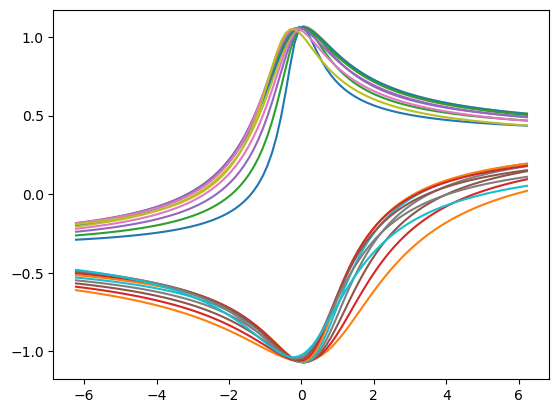

In [8]:
import scipy as sp
import numpy as np
from freecad import part
from freecad import app
from pygears.transformation import numeric_transformation
import matplotlib.pyplot as plt

debug = False
def compute_involute(module=1, teeth=15, height=5, worm_pitch_diameter=10, num_threads=1, alpha=np.deg2rad(20)):
    y = 0.
    xw = worm_pitch_diameter / 2
    
    def r(x, y):
        return (x**2 + y**2)**(0.5)

    def dr_dx(x, y):
        return x / r(x, y)
    
    def z(x, y, t):
        r_xy = r(x, y)
        return module * num_threads * np.arcsin(y / r_xy) / 2 + (r_xy - xw) * np.tan(alpha) + t

    def dz_dx(x, y, t):
        r_xy = r(x, y)
        return np.tan(alpha) * dr_dx(x,y) - module * num_threads * y * dr_dx(x, y) / 2 / np.sqrt(1 - y**2/r_xy**2) / r_xy**2

    def distance_pw(x, y, t):
        return np.sqrt((xw - x) ** 2 + z(x, y, t) ** 2)

    def d_distance_pw_dx(x, y, t):
        return (x - xw + z(x,y,t) * dz_dx(x,y,t)) / np.sqrt((x-xw) ** 2 + z(x,y,t) ** 2)

    def min_root(y, t):
        r0 = xw +  module # * (1 + clearence)
        x0 = np.sqrt(r0**2 - y**2)
        return d_distance_pw_dx(x0, y, t)
        
    def min_head(y, t):
        r1 = xw -  module # * (1 + clearence)
        x1 = np.sqrt(r1**2 - y**2)
        return d_distance_pw_dx(x1, y, t)
        
    xyz = []        
    r0 = xw -  module # * (1 + clearence)
    r1 = xw +  module # * (1 + clearence)
    t_start_0 = (r0 - xw) * (np.tan(alpha) + 1. / np.tan(alpha))
    t_start_1 = (r1 - xw) * (np.tan(alpha) + 1. / np.tan(alpha))
    print(f"t_start_1: {t_start_0}")
    print(f"t_start_0: {t_start_1}")

    for y in np.linspace(- height / 2, height / 3, 20):
        t_i = np.linspace(t_start_0 * 2, t_start_1 * 2, 100)
        plt.plot(t_i, [min_root(y, t) for t in t_i])
        plt.plot(t_i, [min_head(y, t) for t in t_i])
        plt.grid()
        t0 = sp.optimize.root(lambda t: min_head(y, t)**2, t_start_1).x[0]
        t1 = sp.optimize.root(lambda t: min_root(y, t)**2, t_start_0).x[0]
        print(f"t0: {t0}, min: {min_root(y, t0)**2}")
        print(f"t1: {t1}, min: {min_root(y, t0)**2}")        
        print(f"t0_start: {t_start_0}, min: {min_root(y, t_start_0)}")
        print(f"t1_start: {t_start_1}, min: {min_head(y, t_start_1)}")
        for t in np.linspace(t0, t1, 20):
            x_t = sp.optimize.minimize(lambda x: distance_pw(x, y, t), xw).x[0]
            z_t = z(x_t, y, t)
            point = App.Vector(x_t, y, z_t)
            part.show(part.Point(point).toShape())

compute_involute()